# Credit Card Default Prediction

The purpose of this notebook it to construct a full machine learning pipeline to predict the probability of a customer defaulting on their credit card debt. The assignment prompt for this is adapted from an assignment in UBC MDS DSCI 573, but has been reworked. The data is sourced from the Kaggle Credit Card Clients Dataset, found here https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset


# The Problem

The problem is a classification task to identify customers who will default on their credit card payments in the next month. In the raw data set, this column is labeled as `default.payment.next.month`, but this will be re-labeled and referred to to as `default` for convenience. A 0 indicates no default, and a 1 indicates a default. There is significant class imbalance in the dataset, with the majority being non default. As such the analysis will be primarily concerned with metrics related to the identifying the positive class (default), and this can be considered an anomaly detection problem, meaning raw accuracy is an unreliable metric. 

Initial model evaluation will be based on maximal f1 score. This analysis will consider a balanced approach, as we want to avoid casting an overly broad net and having excessive false positives to ensure that intervention as specifically targeted as possible. However, we can consider minimizing false negatives (recall) to be more damaging due to profit loss to the credit card company, while intervention against an individual who would not default may be still warranted if the model identifies them as sufficiently high risk. Overall, we want a somewhat balanced model that still prioritizes minimizing type II error (false negative) over type I error (false postive).

The ideal method would be to set an minimum acceptable operating point for precision, and use this to determine a probability threshold that maximizes recall for each model. The model with the highest recall at this operating point is the model selected by this modeling process. However, setting this operating point requires additional industry knowledge, as well as being specific to the risk tolerance of the company/ deployment context.

# Imports, Download, Reformatting, Splitting

In [81]:
import altair as alt
alt.data_transformers.enable('data_server')
alt.renderers.enable('mimetype')
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline, make_pipeline 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay, confusion_matrix



In [2]:
cc_df = pd.read_csv('data/UCI_Credit_Card.csv').rename(columns = {"default.payment.next.month":"default"})

# Some rows seem to be missing all bill values -- possibly not active customers or error. Drop these
cc_df = cc_df[cc_df.loc[:,'BILL_AMT1':'BILL_AMT6'].sum(axis=1)!=0]

cc_df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [3]:
train_df, test_df = train_test_split(cc_df, test_size=0.20, random_state=123)
train_df.shape

(23304, 25)

In [4]:
test_df.shape

(5826, 25)

# EDA

#### Observations

1. Approximately 22% of examples are default (positive class), 78% are not.
2. We have 24 potential features and one target

Feature Descriptions:

* `ID`: Unique identifier, will be dropped
* `LIMIT_BAL`: Maximum credit, numeric
* `SEX` : Binary/ Numeric. We don't necessarily want to make decisions on default prediction based on sex for ethical reasons, so this will be dropped.
* `EDUCATION`: Ordinal Feature for education level. According to the dataset description, 5 and 6 are unknown. These will be combined into a single category and changed to a value of zero. 
* `MARRIAGE`: Married, Unmarried, Others. This is not ordinal as we don't know relative order, so it will be one hot encoded as a categorical. There are also some unused unlabeled values (54 cases of 0, possibly meaning missing data), which will be combined into others

* `AGE`: a numeric integer
* `PAY_0` -> `PAY_6`: Series of ordinals indicating payment behavior, with 0 being the most recent month at the time of data collection, and each following feature being a month prior. Low values are good payment behaviors (i.e. -1 is paid duly), while positive values indicate how delayed payment is (i.e. 2 is 2 months delayed). There are unlabeled values (0 and -2), I speculate that a 0 is something like partial repayment, and a -2 is overpayment or no credit used. Regardless, these are relative uncommon and will be kept to maintain ordinality. There is obvious correlation between sequential columns, as if an individual is 6 months late in `PAY_0`, we know they must have been 5 months late in `PAY_1`. Conversely, in a predictive sense, if we know `PAY_1` is a large positive number, then that individual is clearly not paying their bill and `PAY_0` is more likely to be the next integer, rather than the individual suddenly paying their bill.
* `BILL_AMT1` -> `BILL_AMT6`: follows same time series as the `PAY` columns. Numeric indicating amount owing
* `PAY_AMT1` -> `PAY_AMT6`: follows same time series as the `PAY` columns. Numeric indicating payment made.


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23304 entries, 23114 to 20565
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         23304 non-null  int64  
 1   LIMIT_BAL  23304 non-null  float64
 2   SEX        23304 non-null  int64  
 3   EDUCATION  23304 non-null  int64  
 4   MARRIAGE   23304 non-null  int64  
 5   AGE        23304 non-null  int64  
 6   PAY_0      23304 non-null  int64  
 7   PAY_2      23304 non-null  int64  
 8   PAY_3      23304 non-null  int64  
 9   PAY_4      23304 non-null  int64  
 10  PAY_5      23304 non-null  int64  
 11  PAY_6      23304 non-null  int64  
 12  BILL_AMT1  23304 non-null  float64
 13  BILL_AMT2  23304 non-null  float64
 14  BILL_AMT3  23304 non-null  float64
 15  BILL_AMT4  23304 non-null  float64
 16  BILL_AMT5  23304 non-null  float64
 17  BILL_AMT6  23304 non-null  float64
 18  PAY_AMT1   23304 non-null  float64
 19  PAY_AMT2   23304 non-null  float64
 20  PA

In [6]:
train_df.nunique()

ID           23304
LIMIT_BAL       80
SEX              2
EDUCATION        7
MARRIAGE         4
AGE             56
PAY_0           11
PAY_2           11
PAY_3           11
PAY_4           11
PAY_5           10
PAY_6           10
BILL_AMT1    18706
BILL_AMT2    18421
BILL_AMT3    18124
BILL_AMT4    17776
BILL_AMT5    17333
BILL_AMT6    17028
PAY_AMT1      6885
PAY_AMT2      6843
PAY_AMT3      6505
PAY_AMT4      6025
PAY_AMT5      5966
PAY_AMT6      5987
default          2
dtype: int64

In [7]:
prop_neg = round(train_df['default'].value_counts()[0]/train_df.shape[0],2)
prop_pos = round(train_df['default'].value_counts()[1]/train_df.shape[0],2)

print (f"Proportion of positive class: {prop_pos}")
print (f"Proportion of negative class: {prop_neg}")

Proportion of positive class: 0.22
Proportion of negative class: 0.78


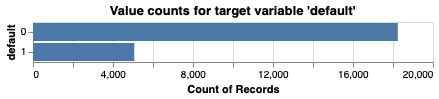

In [8]:
alt.Chart(train_df,title = "Value counts for target variable 'default'").mark_bar().encode(
    y = alt.Y("default:N"),
    x = alt.X("count()"))

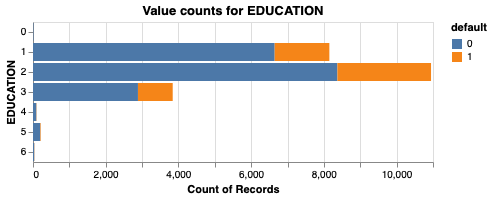

In [9]:
alt.Chart(train_df,title = "Value counts for EDUCATION").mark_bar().encode(
    y = alt.Y("EDUCATION:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

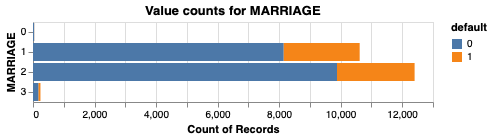

In [10]:
alt.Chart(train_df,title = "Value counts for MARRIAGE").mark_bar().encode(
    y = alt.Y("MARRIAGE:N"),
    x = alt.X("count()"),
color = alt.Color('default:N'))

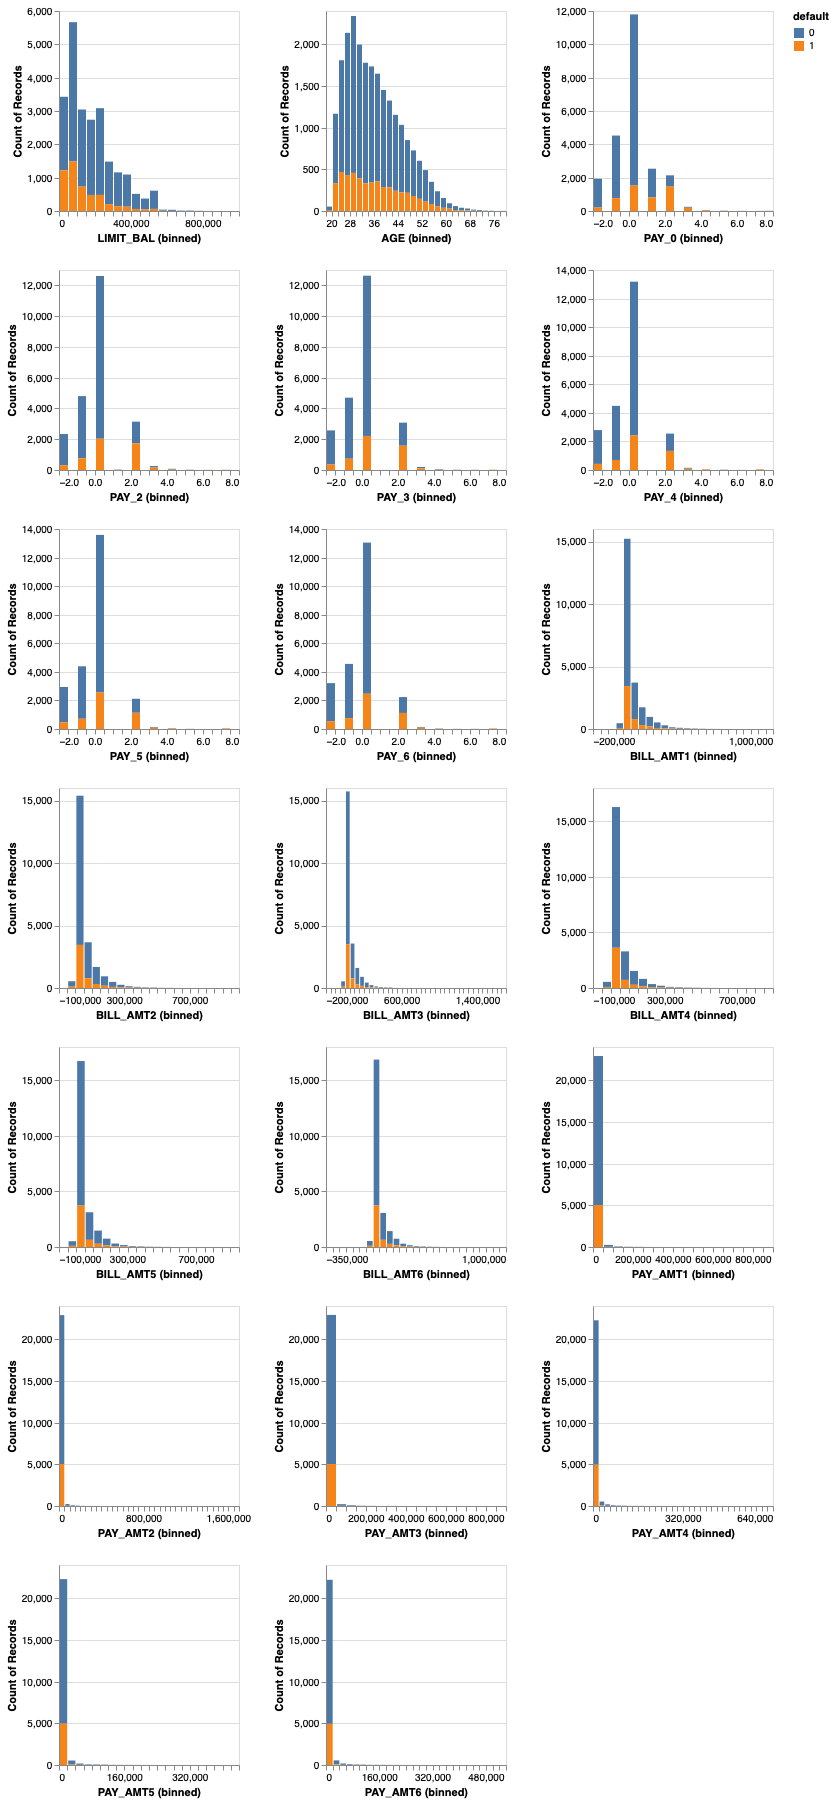

In [11]:
numeric_cols = train_df.select_dtypes(
    include=np.number).drop(
    columns=["ID", "SEX", "default", "MARRIAGE", "EDUCATION"]).columns.to_list()

alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
    color='default:N'
).properties(
    width=180,
    height=200
).repeat(
    numeric_cols, columns=3
)

In [12]:
train_df[numeric_cols].corr('kendall').style.background_gradient()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
LIMIT_BAL,1.000000,0.131779,-0.237038,-0.268373,-0.258503,-0.240751,-0.219675,-0.205549,0.092536,0.087368,0.092922,0.096039,0.098858,0.102886,0.228964,0.231723,0.236109,0.233656,0.241166,0.256385
AGE,0.131779,1.000000,-0.050595,-0.060349,-0.060294,-0.058086,-0.059998,-0.056172,0.011452,0.012238,0.012562,0.008041,0.009296,0.008717,0.033434,0.041956,0.032843,0.036711,0.034340,0.035305
PAY_0,-0.237038,-0.050595,1.000000,0.651403,0.547391,0.515548,0.485602,0.456179,0.266036,0.268999,0.258192,0.251179,0.243244,0.235635,-0.077176,-0.045156,-0.041377,-0.026940,-0.020122,-0.034307
PAY_2,-0.268373,-0.060349,0.651403,1.000000,0.744246,0.643324,0.600948,0.556894,0.401564,0.388627,0.362467,0.345491,0.330518,0.317540,-0.044585,0.008570,0.010722,0.019331,0.023161,0.014554
PAY_3,-0.258503,-0.060294,0.547391,0.744246,1.000000,0.746045,0.647590,0.595340,0.361118,0.418469,0.397471,0.375386,0.356580,0.340381,0.121662,-0.032065,0.022285,0.040792,0.044929,0.029804
PAY_4,-0.240751,-0.058086,0.515548,0.643324,0.746045,1.000000,0.771896,0.662369,0.352158,0.393205,0.450043,0.432896,0.404379,0.383764,0.093141,0.148982,-0.009804,0.059728,0.076699,0.067910
PAY_5,-0.219675,-0.059998,0.485602,0.600948,0.647590,0.771896,1.000000,0.770312,0.346392,0.381283,0.426259,0.485475,0.462619,0.428011,0.085656,0.128916,0.160215,0.029647,0.097097,0.093750
PAY_6,-0.205549,-0.056172,0.456179,0.556894,0.595340,0.662369,0.770312,1.000000,0.334737,0.366422,0.400358,0.443267,0.501123,0.471536,0.085051,0.105313,0.139497,0.181310,0.054586,0.110936
BILL_AMT1,0.092536,0.011452,0.266036,0.401564,0.361118,0.352158,0.346392,0.334737,1.000000,0.806192,0.725998,0.656554,0.609968,0.571007,0.367968,0.337232,0.304537,0.305664,0.290182,0.282848
BILL_AMT2,0.087368,0.012238,0.268999,0.388627,0.418469,0.393205,0.381283,0.366422,0.806192,1.000000,0.799521,0.712527,0.652694,0.608829,0.486725,0.364077,0.331197,0.324764,0.313073,0.302004


In [13]:
# recategorizing classses 0, 5, 6 in education as "Others" for train
train_df['EDUCATION'] = train_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for train
train_df['MARRIAGE'] = train_df['MARRIAGE'].replace(0, 3)

# recategorizing classses 0, 5, 6 in education as "Others" for test
test_df['EDUCATION'] = test_df['EDUCATION'].replace([0, 5, 6], 4)

# recategorizing class 0 in marriage as "Others" for test                
test_df['MARRIAGE'] = test_df['MARRIAGE'].replace(0, 3)

# Feature Engineering

1. **Max of `PAY` series**: The `PAY` series of features provides a qualitative description of the pay behavior of a customer in a given month. As previously discussed, when a customer repeatedly does not pay their balance across multiple months, this series of features becomes sequential. We can create a feature that describes a customer's overall worst case payment behavior (longest time without a payment) in a single feature by taking the max of these features.

2. **Sum of `BILL_AMT` series**: The `BILL` series describes the amount of money owed by the customer. Instead of dividing this over multiple features, it may be useful to condense it into a single feature correlated to the total amount of money owed. Note that this value is not necessarily the sum of charges on the card, as an unpaid charge of \$2000 in `BILL_AMT_6` would be carried forward into `BILL_AMT_5`, giving this feature a value of \$4000 without any additional spending occurring. 

3. **Sum of `PAY_AMT` series**: The `PAY_AMT` series describes the amount of money paid by the customer. Similar to the above, it may be helpful to summarize this value into a single feature. Note that this value should actually be equal to the total amount paid by the customer, as the values each month are not carried forward as in the case of unpaid bills.

4. **Payment Ratio**: This feature will describe the mean proportion of their bill that a customer pays off. For example, for a single month we would compute `PAY_AMT1` / `BILL_AMT2` (adjusted for payment time lag). This would be equal to 1 for a full repayment, 0 for no payment, and somewhere between 0 and 1 for a partial repayment. This calculation is repeated for all Pay/Bill pairs and averaged to find the mean ratio. Note that to prevent division by zero, if the `BILL_AMT` is equal to 0, we will set the pay ratio to 1.

In [14]:
# creating total_pay for train
train_df = train_df.assign(longest_unpaid_streak=train_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for train
train_df = train_df.assign(total_bill=train_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for train
train_df = train_df.assign(total_paid=train_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for train (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(train_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(train_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
train_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

# creating total_pay for test
test_df = test_df.assign(longest_unpaid_streak=test_df.loc[:, "PAY_0":"PAY_6"].max(axis=1))

# creating total_bill for test
test_df = test_df.assign(total_bill=test_df.loc[:, "BILL_AMT1":"BILL_AMT6"].sum(axis=1))

# creating total_paid for test
test_df = test_df.assign(total_paid=test_df.loc[:, "PAY_AMT1":"PAY_AMT6"].sum(axis=1))

# creating avg_pay_ratio for test (assumption: if bill_amt = 0, pay_ratio = 1)
np_pay_amt = np.array(test_df.loc[:, "PAY_AMT1":"PAY_AMT5"])
np_bill_amt = np.array(test_df.loc[:, "BILL_AMT2":"BILL_AMT6"])
test_df['avg_pay_ratio'] = np.average(np.divide(np_pay_amt, np_bill_amt, out=np.ones_like(np_pay_amt), where=np_bill_amt!=0), axis=1)

# Preprocessing, X/y split

* We will drop `ID` (unique identifier) and `Sex` (ethical concerns, don't want to deny credit based on sex)
* `MARRIAGE` will be considered a categorical -- not sure if the ordering is sequential
* `EDUCATION` will be considered an ordinal -- values ordered from less to more education.
* All other features are numeric. `PAY` variables could be encoded as ordinal, but because they are already in ordered numeric format it is fine to interpret them as standard numerics.


In [15]:
# Creating X_train, y_train, X_test and y_test
X_train = train_df.drop(columns='default')
y_train = train_df['default']
X_test = test_df.drop(columns='default')
y_test = test_df['default']


# Creating the preprocessor

drop_features = ['ID', 'SEX']
numeric_features = ['LIMIT_BAL', 'AGE',
                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                    'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
                    'longest_unpaid_streak', 'total_bill', 'total_paid', 'avg_pay_ratio']
ordinal_features = ['EDUCATION']
categorical_features = ['MARRIAGE']

ordinal_levels = [1, 2, 3, 4]

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OrdinalEncoder(categories=[ordinal_levels]), ordinal_features),
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_features),
    ("drop", drop_features)   
)


# Baseline Dummy Model

Set up a dummy model as a baseline. Because the Dummy will always predict no default, we see 0 in all scoring metrics besides accuracy (no True Positives or False Positives)

In [16]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

classification_metrics = ["accuracy", "precision", "recall", "f1"]
dc = DummyClassifier()
cross_val_results = {}
cross_val_results['Dummy'] = (pd.DataFrame(cross_validate(dc,
                                                         X_train,
                                                         y_train,
                                                         return_train_score=True,
                                                         scoring=classification_metrics))
                              .agg(['mean', 'std']).round(3).T)

# Show the train and validation scores
cross_val_results['Dummy']

,mean,std
fit_time,0.002,0.001
score_time,0.003,0.000
test_accuracy,0.783,0.000
train_accuracy,0.783,0.000
test_precision,0.000,0.000
train_precision,0.000,0.000
test_recall,0.000,0.000
train_recall,0.000,0.000
test_f1,0.000,0.000
train_f1,0.000,0.000



# Linear Model -- Logistic Regression

CV f1 score is 0.520. 

CV f1 score is very close to train f1 score (0.521) so we are likely not overfitting.

Note that `class_weight` is set to balanced rather than being tuned. While overall scoring is in terms of f1 because precision is still relevant and we don't have an ideal operating point, high recall is more significant than high precision because we want to capture as many defaults as possible to minimize losses (within a reasonable minimum precision). Because setting `class_weight` to balanced in this case causes the model to consider the less common positive class evenly, it will result in more positive predictions, and therefore higher recall. Scoring f1 with `class_weight = balanced` is an acceptable compromise to ensure a relatively balanced result skewed towards higher recall when we do not have an operating point

`class_weight` will be set to balanced for all future models where possible

In [17]:
from scipy.stats import lognorm, loguniform, randint

pipe_logreg = make_pipeline(preprocessor, LogisticRegression(random_state=123,
                                                        max_iter=1000, class_weight = 'balanced'))

param_dist_logreg = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg = RandomizedSearchCV(
    pipe_logreg,
    param_distributions=param_dist_logreg,
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring = 'f1')
random_search_logreg.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['MARRIAGE']),
                                                                              ('drop',
                                                                               'drop',
                                                                               ['ID',
                                                                                'SEX'])])),
                                             ('logisticregression',
                                              LogisticRegression(class_weight='balanced',
                                                                 max_iter=1000,
                                                                 random_state=123))]),
                   n_iter=50,
                   param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x13ccfa830>},
                   random_state=123, return_train_score=True, scoring='f1')

In [18]:
random_search_logreg.best_params_

{'logisticregression__C': 0.003569682906906476}

In [19]:
cross_val_results['Logreg'] = pd.DataFrame(cross_validate(random_search_logreg.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['Logreg']

,mean,std
fit_time,0.041,0.001
score_time,0.007,0.001
test_accuracy,0.741,0.006
train_accuracy,0.742,0.002
test_precision,0.435,0.007
train_precision,0.437,0.003
test_recall,0.647,0.015
train_recall,0.648,0.001
test_f1,0.520,0.002
train_f1,0.522,0.003


# Nonlinear Models

For the following models, we will investigate their scores without optimization, then try hyperparameter tuning after 
feature selection

* Naive Bayes 
* Random Forest
* LightGBM

## Naive Bayes - Baseline

Untuned Naive Bayes has an extremely high recall score (0.865), but very low precision (0.260), indicating that it is casting a very wide net. As a result, f1 score is not great (0.399)

In [20]:
NB = make_pipeline(preprocessor, GaussianNB())

cross_val_results['NB'] = pd.DataFrame(cross_validate(NB,
                                  X_train,
                                  y_train,
                                  return_train_score=True,
                                  scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['NB']

,mean,std
fit_time,0.013,0.001
score_time,0.008,0.001
test_accuracy,0.434,0.032
train_accuracy,0.434,0.032
test_precision,0.260,0.009
train_precision,0.260,0.008
test_recall,0.865,0.022
train_recall,0.866,0.029
test_f1,0.399,0.008
train_f1,0.399,0.006


## Random Forest

Untuned Random Forest seems to have a moderate/ low f1 score (0.456), and even with balanced class weight seems to significantly favor precision (0.674) over recall (0.345)

In [21]:
RF = make_pipeline(preprocessor,
                       RandomForestClassifier(class_weight="balanced", n_estimators = 100, random_state=123))

cross_val_results['RF'] = pd.DataFrame(cross_validate(RF,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF'] 

,mean,std
fit_time,3.668,0.124
score_time,0.071,0.006
test_accuracy,0.821,0.002
train_accuracy,1.000,0.000
test_precision,0.674,0.017
train_precision,1.000,0.000
test_recall,0.345,0.012
train_recall,1.000,0.000
test_f1,0.456,0.008
train_f1,1.000,0.000


## LightGBM

Untuned LightGBM seems to have a decent recall (0.610) and precision (0.474), resulting in a moderate f1 score (0.533). 

Thus far this is the strongest model, outperforming the other nonlinear models and the tuned linear model.

In [22]:
LGBM = make_pipeline(preprocessor,
                         LGBMClassifier(class_weight="balanced", n_estimators = 100, random_state=123))

cross_val_results['LGBM'] = pd.DataFrame(cross_validate(LGBM,
                                                            X_train,
                                                            y_train,
                                                            return_train_score=True,
                                                            scoring=classification_metrics)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['LGBM']

,mean,std
fit_time,0.371,0.017
score_time,0.014,0.002
test_accuracy,0.768,0.006
train_accuracy,0.830,0.003
test_precision,0.474,0.009
train_precision,0.582,0.007
test_recall,0.610,0.018
train_recall,0.778,0.009
test_f1,0.533,0.005
train_f1,0.666,0.005


## Combined Results

In [23]:
combined_results = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

combined_results

,Dummy,Logreg,NB,RF,LGBM
fit_time,0.002,0.041,0.013,3.668,0.371
score_time,0.003,0.007,0.008,0.071,0.014
test_accuracy,0.783,0.741,0.434,0.821,0.768
train_accuracy,0.783,0.742,0.434,1.000,0.830
test_precision,0.000,0.435,0.260,0.674,0.474
train_precision,0.000,0.437,0.260,1.000,0.582
test_recall,0.000,0.647,0.865,0.345,0.610
train_recall,0.000,0.648,0.866,1.000,0.778
test_f1,0.000,0.520,0.399,0.456,0.533
train_f1,0.000,0.522,0.399,1.000,0.666


# Feature Selection

We'll attempt to use feature selection to remove irrelevant features to reduce the complexity of our model. 

Our original dataset has 28 features. Because we have significant correlation in some features  we will use `RFECV` wit `Ridge` since it is robust to multicolinearity. 

Additionally, because this data is time-series like (i.e. the `PAY` series of features that describes an individual's behavior over multiple months, with each entry being influenced by the previous), feature selection may help us to reduce redundancy. We can logically suggest that pay behavior six months prior to assessment is less likely to be relevant than the most recent pay behavior for predicting a default. If we know that `PAY_0` is a large positive number, we know all of the previous `PAY` entries as well, and in this case the previous entries are redundant. 

Also, because we created some engineered features that summarize the overall/ worst case behavior of these series, these features may more efficiently capture the encoded patterns, and may reduce the importance of the individual features enough for us to eliminate them. We will be able to get a better idea of which features are most important later.

In [24]:
#Baseline feature counts

pipe_logreg.fit(X_train, y_train) 
pipe_logreg.named_steps["logisticregression"].n_features_in_

28

## Logistic Regression

In [25]:
logreg_RFE = make_pipeline(preprocessor,
                           RFECV(RidgeClassifier(), cv=10),
                           LogisticRegression(class_weight="balanced",
                                              random_state=123,
                                              max_iter=1000))

param_dist = {
    "logisticregression__C": loguniform(1e-3, 1e3)
}

random_search_logreg_RFE = RandomizedSearchCV(
    logreg_RFE,
    param_distributions=param_dist,
    n_jobs=-1, 
    n_iter=20,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)
random_search_logreg_RFE.fit(X_train, y_train)

cross_val_results['Logreg_RFE'] = pd.DataFrame(cross_validate(random_search_logreg_RFE.best_estimator_,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

In [26]:
df = pd.concat([cross_val_results['Logreg'], cross_val_results['Logreg_RFE']], axis=1)
df.columns=['logreg mean', 'logreg std', 'logreg_RFE mean', 'logreg_RFE std']
df

,logreg mean,logreg std,logreg_RFE mean,logreg_RFE std
fit_time,0.041,0.001,1.245,0.132
score_time,0.007,0.001,0.006,0.001
test_accuracy,0.741,0.006,0.742,0.003
train_accuracy,0.742,0.002,0.742,0.002
test_precision,0.435,0.007,0.437,0.003
train_precision,0.437,0.003,0.436,0.002
test_recall,0.647,0.015,0.638,0.014
train_recall,0.648,0.001,0.638,0.003
test_f1,0.520,0.002,0.518,0.004
train_f1,0.522,0.003,0.518,0.002


In [27]:
# Resulting number of features

logreg_RFE.fit(X_train, y_train)
logreg_RFE.named_steps["logisticregression"].n_features_in_

5

In [28]:
# Get names of selected features 

mask = logreg_RFE.named_steps["rfecv"].support_
feature_names = numeric_features + ordinal_features + ['Marriage1', 'Marriage2', 'Marriage3']
names_array = np.array(feature_names)
names_array[mask]


array(['PAY_0', 'PAY_2', 'BILL_AMT1', 'longest_unpaid_streak',
       'Marriage1'], dtype='<U21')

## Naive Bayes

In [29]:
NB_RFE = make_pipeline(preprocessor, RFECV(RidgeClassifier(), cv=10), GaussianNB())

cross_val_results['NB_RFE'] = pd.DataFrame(cross_validate(NB_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

In [30]:
df = pd.concat([cross_val_results['NB'], cross_val_results['NB_RFE']], axis=1)
df.columns=['NB mean', 'NB std', 'NB_RFE mean', 'NB_RFE std']
df

,NB mean,NB std,NB_RFE mean,NB_RFE std
fit_time,0.013,0.001,1.135,0.028
score_time,0.008,0.001,0.006,0.001
test_accuracy,0.434,0.032,0.809,0.005
train_accuracy,0.434,0.032,0.809,0.003
test_precision,0.260,0.009,0.569,0.015
train_precision,0.260,0.008,0.570,0.010
test_recall,0.865,0.022,0.500,0.022
train_recall,0.866,0.029,0.501,0.004
test_f1,0.399,0.008,0.532,0.013
train_f1,0.399,0.006,0.533,0.003


## Random Forest

In [31]:
RF_RFE = make_pipeline(preprocessor,
                           RFECV(RidgeClassifier(), cv=10),
                           RandomForestClassifier(class_weight="balanced", random_state=123))

cross_val_results['RF_RFE'] = pd.DataFrame(cross_validate(RF_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

In [32]:
df = pd.concat([cross_val_results['RF'], cross_val_results['RF_RFE']], axis=1)
df.columns=['RF mean', 'RF std', 'RF_RFE mean', 'RF_RFE std']
df

,RF mean,RF std,RF_RFE mean,RF_RFE std
fit_time,3.668,0.124,2.641,0.352
score_time,0.071,0.006,0.072,0.004
test_accuracy,0.821,0.002,0.768,0.048
train_accuracy,1.000,0.000,0.987,0.011
test_precision,0.674,0.017,0.497,0.152
train_precision,1.000,0.000,0.965,0.032
test_recall,0.345,0.012,0.378,0.024
train_recall,1.000,0.000,0.978,0.020
test_f1,0.456,0.008,0.419,0.043
train_f1,1.000,0.000,0.971,0.026


## LightGBM

In [33]:
LGBM_RFE = make_pipeline(preprocessor,
                             RFECV(RidgeClassifier(), cv=10),
                             LGBMClassifier(class_weight="balanced", random_state=123))

cross_val_results['LGBM_RFE'] = pd.DataFrame(cross_validate(LGBM_RFE,
                                                          X_train,
                                                          y_train,
                                                          return_train_score=True,
                                                          scoring=classification_metrics)).agg(['mean', 'std']).round(3).T



In [34]:
df = pd.concat([cross_val_results['LGBM'], cross_val_results['LGBM_RFE']], axis=1)
df.columns=['LGBM mean', 'LGBM std', 'LGBM_RFE mean', 'LGBM_RFE std']
df

,LGBM mean,LGBM std,LGBM_RFE mean,LGBM_RFE std
fit_time,0.371,0.017,1.390,0.052
score_time,0.014,0.002,0.011,0.001
test_accuracy,0.768,0.006,0.765,0.009
train_accuracy,0.830,0.003,0.792,0.011
test_precision,0.474,0.009,0.469,0.015
train_precision,0.582,0.007,0.516,0.019
test_recall,0.610,0.018,0.603,0.022
train_recall,0.778,0.009,0.675,0.060
test_f1,0.533,0.005,0.527,0.002
train_f1,0.666,0.005,0.584,0.034


## Feature Selection Conclusions

In [36]:
del cross_val_results['Dummy']

combined_results_fs = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
   precision=3
)

combined_results_fs
col_list = combined_results_fs.columns.tolist()
col_list.sort()
col_list
combined_results_fs = combined_results_fs.data
combined_results_fs[col_list]

,LGBM,LGBM_RFE,Logreg,Logreg_RFE,NB,NB_RFE,RF,RF_RFE
fit_time,0.371,1.390,0.041,1.245,0.013,1.135,3.668,2.641
score_time,0.014,0.011,0.007,0.006,0.008,0.006,0.071,0.072
test_accuracy,0.768,0.765,0.741,0.742,0.434,0.809,0.821,0.768
train_accuracy,0.830,0.792,0.742,0.742,0.434,0.809,1.000,0.987
test_precision,0.474,0.469,0.435,0.437,0.260,0.569,0.674,0.497
train_precision,0.582,0.516,0.437,0.436,0.260,0.570,1.000,0.965
test_recall,0.610,0.603,0.647,0.638,0.865,0.500,0.345,0.378
train_recall,0.778,0.675,0.648,0.638,0.866,0.501,1.000,0.978
test_f1,0.533,0.527,0.520,0.518,0.399,0.532,0.456,0.419
train_f1,0.666,0.584,0.522,0.518,0.399,0.533,1.000,0.971


RFECV reduces us from a baseline of 28 features to 5 features. These features are (in no order, we will investigate that later), `PAY_0`, `PAY_2`, `BILL_AMT_1`, `longest_unpaid_streak`, and `Marriage1`. This is the payment behavior (i.e. pay duly, defer payment) for the two most recent months, the most recent bill amount due, the individuals longest streak of deferred payments (worst case behavior), and whether or not the individual is married. 

Overall results from feature selection are shown above. Based on these results, we will choose to either apply or not apply feature selection for each model for future steps (rationale below):

* **Logistic Regression**: We see an extremely minimal loss of f1 score resulting from feature selection, and a significant increase in fitting time. While a 5 feature model has the benefit of increased interpretability compared to a 28 feature model, even complex Logisitic Regressions are still (relatively speaking) easy to interpret. Because of this, the increased interpretability of the feature selected model isn't really worth the slight dip in performance, and running RFECV takes significantly longer than running the 28 feature regression, so we won't use feature selection.
* **Naive Bayes**: Naive Bayes does poorly with unimportant features because it doesn't have a method to handle feature importances. Because of this feature selection to include only useful features improves the model. While recall decreases, precision is much higher (no longer casting an extremely wide net), and overall f1 is much higher. We will keep feature selection for NB
* **Random Forests**: Because Random Forests are computationally intensive, employing feature selection does decrease the fitting time for the RF model. We can expect the difference to be even larger if we opted to increase the computational budget (`n_estimators` hyperparam) because the RFECV time is fixed, but the fit time per tree is lower. However, f1 score is significantly lower after feature selection for RF, so it is not worth it, and we won't use feature selection. 
* **LightGBM**: Similar to Logistic Regression, we see a small decrease in f1 score and significant increase in fit time after feature selection. Because LightGBM also has an `n_estimators` parameter, there is a theoretical point where the decreased time to fit each tree will result in more time saved than feature selection 'costs' but based on this score the default 100 estimators is quite far off this. Overall, despite the fact that a 5 feature model is more interpretable than a 28 feature model, even a 5 feature gradient boosted tree is difficult to interpret by nature of the algorithm (we'll deploy eli5 and SHAP to help us), and the slight improvement is not worth the drop in performance. We won't use feature selection.



# Hyperparameter Optimization

We already optimized our linear model, so we can continue forward with our previous model (contained in object `random_search_logreg`)

## Naive Bayes


In [37]:
param_dist_nb = {
    "gaussiannb__var_smoothing": np.logspace(0, -9, num=100)
}

# using feature selected NB 

random_search_NB = RandomizedSearchCV(
    NB_RFE,
    param_distributions=param_dist_nb,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)
random_search_NB.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
                   random_state=123, return_train_score=True, scoring='f1')

In [38]:
random_search_NB.best_params_

{'gaussiannb__var_smoothing': 0.0533669923120631}

In [39]:
cross_val_results['NB_opt'] = pd.DataFrame(
    cross_validate(random_search_NB.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['NB_opt'] 

,mean,std
fit_time,1.279,0.150
score_time,0.006,0.001
test_accuracy,0.811,0.004
train_accuracy,0.811,0.002
test_precision,0.575,0.012
train_precision,0.574,0.006
test_recall,0.499,0.021
train_recall,0.498,0.004
test_f1,0.534,0.014
train_f1,0.533,0.004


## Random Forest

In [40]:
param_dist_rf = {
    "randomforestclassifier__max_depth": randint(1,20),
    "randomforestclassifier__max_features": randint(1,28)
}

random_search_RF = RandomizedSearchCV(
    RF,
    param_distributions=param_dist_rf,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='f1'
)

In [41]:
random_search_RF.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PAY_AMT6',
                                                                                'longest_unp...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13f8fe590>,
                                        'randomforestclassifier__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13ccf8c40>},
                   random_state=123, return_train_score=True, scoring='f1')

In [42]:
random_search_RF.best_params_

{'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__max_features': 4}

In [43]:
cross_val_results['RF_opt'] = pd.DataFrame(
    cross_validate(random_search_RF.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics,
                  n_jobs=-1)).agg(['mean', 'std']).round(3).T
# Show the train and validation scores
cross_val_results['RF_opt'] 

,mean,std
fit_time,3.184,0.036
score_time,0.060,0.002
test_accuracy,0.795,0.005
train_accuracy,0.845,0.002
test_precision,0.526,0.010
train_precision,0.632,0.005
test_recall,0.563,0.015
train_recall,0.682,0.004
test_f1,0.543,0.008
train_f1,0.656,0.002


## LightGBM



In [44]:
param_dist_lgbm = {
    "lgbmclassifier__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    "lgbmclassifier__max_depth": randint(-1, 10),
    "lgbmclassifier__num_leaves": [2, 3, 5, 10, 25, 50, 100]}

random_search_LGBM = RandomizedSearchCV(
    LGBM,
    param_distributions=param_dist_lgbm,
    n_jobs=-1, 
    n_iter=50,
    random_state=123,
    return_train_score=True,
    scoring='f1',
    error_score = 'raise')

In [45]:
random_search_LGBM.fit(X_train, y_train)

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['LIMIT_BAL',
                                                                                'AGE',
                                                                                'PAY_0',
                                                                                'PAY_2',
                                                                                'PAY_3',
                                                                                'PAY_4',
                                                                                'PAY_5',
                                                                                'PAY_6',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT2',
                                                                                'BILL_AMT3',
                                                                                'BILL_AMT4',
                                                                                'BILL_AMT5',
                                                                                'BILL_AMT6',
                                                                                'PAY_AMT1',
                                                                                'PAY_AMT2',
                                                                                'PAY_AMT3',
                                                                                'PAY_AMT4',
                                                                                'PAY_AMT5',
                                                                                'PA...
                                              LGBMClassifier(class_weight='balanced',
                                                             random_state=123))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'lgbmclassifier__learning_rate': [0.0001,
                                                                          0.001,
                                                                          0.01,
                                                                          0.1,
                                                                          0.2,
                                                                          0.3],
                                        'lgbmclassifier__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x13f8f9ed0>,
                                        'lgbmclassifier__num_leaves': [2, 3, 5,
                                                                       10, 25,
                                                                       50,
                                                                       100]},
                   random_state=123, return_train_score=True, scoring='f1')

In [46]:
random_search_LGBM.best_params_

{'lgbmclassifier__learning_rate': 0.2,
 'lgbmclassifier__max_depth': 2,
 'lgbmclassifier__num_leaves': 3}

In [47]:
cross_val_results['LGBM_opt'] = pd.DataFrame(
    cross_validate(random_search_LGBM.best_estimator_,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

# Show the train and validation scores
cross_val_results['LGBM_opt'] 

,mean,std
fit_time,0.106,0.003
score_time,0.010,0.000
test_accuracy,0.763,0.005
train_accuracy,0.767,0.002
test_precision,0.467,0.007
train_precision,0.474,0.003
test_recall,0.633,0.012
train_recall,0.644,0.004
test_f1,0.537,0.004
train_f1,0.546,0.001


## Hyperparam Tuning Results

In [48]:
combined_results_opt = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]

,LGBM,LGBM_RFE,LGBM_opt,Logreg,Logreg_RFE,NB,NB_RFE,NB_opt,RF,RF_RFE,RF_opt
fit_time,0.371,1.390,0.106,0.041,1.245,0.013,1.135,1.279,3.668,2.641,3.184
score_time,0.014,0.011,0.010,0.007,0.006,0.008,0.006,0.006,0.071,0.072,0.060
test_accuracy,0.768,0.765,0.763,0.741,0.742,0.434,0.809,0.811,0.821,0.768,0.795
train_accuracy,0.830,0.792,0.767,0.742,0.742,0.434,0.809,0.811,1.000,0.987,0.845
test_precision,0.474,0.469,0.467,0.435,0.437,0.260,0.569,0.575,0.674,0.497,0.526
train_precision,0.582,0.516,0.474,0.437,0.436,0.260,0.570,0.574,1.000,0.965,0.632
test_recall,0.610,0.603,0.633,0.647,0.638,0.865,0.500,0.499,0.345,0.378,0.563
train_recall,0.778,0.675,0.644,0.648,0.638,0.866,0.501,0.498,1.000,0.978,0.682
test_f1,0.533,0.527,0.537,0.520,0.518,0.399,0.532,0.534,0.456,0.419,0.543
train_f1,0.666,0.584,0.546,0.522,0.518,0.399,0.533,0.533,1.000,0.971,0.656


Full results table is shown above. We can see that we were able to improve f1 score for all models using hyperparameter tuning (`logreg` shown is the optimized model). Interestingly, we were able to bring all models up to relative parity, with test f1 scores ranging from 0.520 (Logistic Regression) to 0.543 (Random Forest). It is worth noting that we could probably improve the score for RF and LGBM further by increasing the `n_estimators` hyperparam, but doing so would depend on the computational budget. If this model was being deployed with sufficient computing resources available, higher `n_estimators` values could also be tested (theoretically providing better results). 

The best recall scores are provided by LGBM and Logistic Regression (0.633 and 0.647 respectively). Naive Bayes has the lowest recall (0.499), but because of its higher precision still has a strong f1 score. 

# Testing a Diversified Ensemble

These models are all performing fairly similarly, with comparable f1 scores, and varying ratios of precision and recall. Because they are different model types (linear, bayesian, tree ensemble, gradient boosted tree), it is reasonable to suppose that they will make different 'kinds of errors', making errors on different examples. It is worth investigating if creating an ensemble meta-model of our adequately performing models provides sufficient improvement to justify increased model complexity.

We do encounter a problem with this strategy. If we employ `voting = 'hard'`, we have 4 models, and so it is possible to get 2-2 ties. If we use `voting = 'soft'`, we probably should not include Naive Bayes as, while it is a good classifier, it is a very poor estimator of probability, so we shouldn't use it in a soft voting ensemble. 

To solve this, we will opt to drop NB and use soft voting. The alternative is to drop any of the four models and use hard voting, but in this context it may be best to drop NB anyways due to its low recall (Linear Regression has slightly lower f1 but high recall, which is desirable in this case). We are regardless left with a three model system, and opt to use soft voting as it factors in model confidence to created a weighted model, which is probably more accurate.  

In [49]:
final_classifiers =  {
    "Logistic Regression": random_search_logreg.best_estimator_,
    "Random Forest": random_search_RF.best_estimator_,
    "LightGBM": random_search_LGBM.best_estimator_,
}


In [50]:
averaged_model = VotingClassifier(
    list(final_classifiers.items()), voting='soft')

In [51]:
cross_val_results['Averaged'] = pd.DataFrame(
    cross_validate(averaged_model,
                   X_train,
                   y_train,
                   return_train_score=True,
                   scoring=classification_metrics)).agg(['mean', 'std']).round(3).T

cross_val_results['Averaged']

,mean,std
fit_time,2.236,0.125
score_time,0.050,0.002
test_accuracy,0.776,0.006
train_accuracy,0.794,0.002
test_precision,0.488,0.011
train_precision,0.521,0.003
test_recall,0.604,0.016
train_recall,0.640,0.003
test_f1,0.540,0.007
train_f1,0.574,0.002


# Model Evaluation and Selection

We will now investigate each optimized model further using the previous classification metrics, PR and ROC curves, and Confusion Matrices before making a final decision on the best model.  

In [59]:
combined_results_opt = pd.concat(
    cross_val_results,
    axis='columns'
).xs(
    'mean',
    axis='columns',
    level=1
).style.format(
    precision=3
)

col_list_opt = combined_results_opt.columns.tolist()
col_list_opt.sort()
indices = [0,3,4,8,11]
col_list_opt = [col_list_opt[i] for i in indices]
combined_results_opt = combined_results_opt.data
combined_results_opt[col_list_opt]



,Averaged,LGBM_opt,Logreg,NB_opt,RF_opt
fit_time,2.236,0.106,0.041,1.279,3.184
score_time,0.050,0.010,0.007,0.006,0.060
test_accuracy,0.776,0.763,0.741,0.811,0.795
train_accuracy,0.794,0.767,0.742,0.811,0.845
test_precision,0.488,0.467,0.435,0.575,0.526
train_precision,0.521,0.474,0.437,0.574,0.632
test_recall,0.604,0.633,0.647,0.499,0.563
train_recall,0.640,0.644,0.648,0.498,0.682
test_f1,0.540,0.537,0.520,0.534,0.543
train_f1,0.574,0.546,0.522,0.533,0.656


Text(0.5, 1.0, 'Precision-Recall Curves')

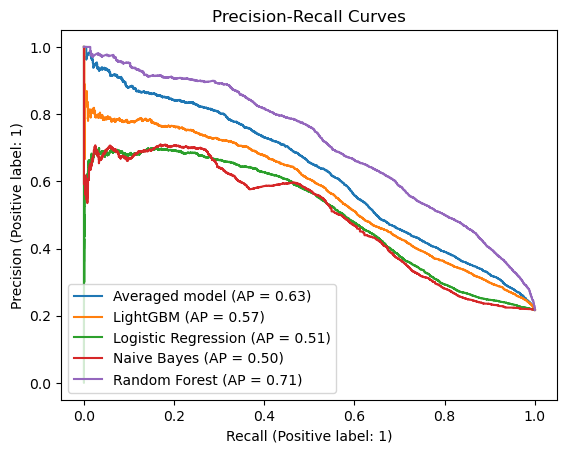

In [72]:
averaged_model.fit(X_train, y_train)

PrecisionRecallDisplay.from_estimator(averaged_model, X_train, y_train, ax = plt.gca(), name = "Averaged model")
PrecisionRecallDisplay.from_estimator(random_search_LGBM.best_estimator_, X_train, y_train, ax = plt.gca(), name = "LightGBM")
PrecisionRecallDisplay.from_estimator(random_search_logreg.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Logistic Regression")
PrecisionRecallDisplay.from_estimator(random_search_NB.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Naive Bayes")
PrecisionRecallDisplay.from_estimator(random_search_RF.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Random Forest")

plt.title('Precision-Recall Curves')


Text(0.5, 1.0, 'ROC Curves')

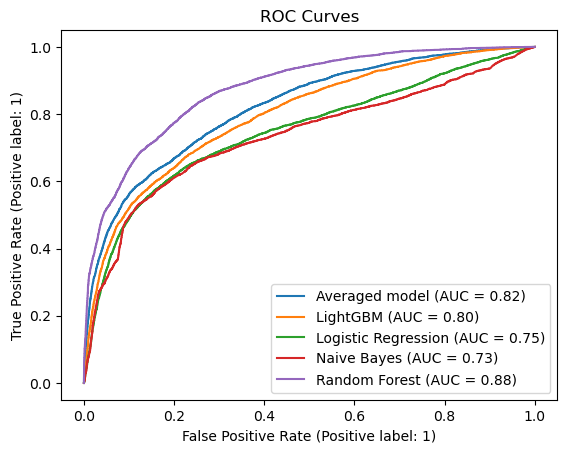

In [74]:
RocCurveDisplay.from_estimator(averaged_model, X_train, y_train, ax = plt.gca(), name = "Averaged model")
RocCurveDisplay.from_estimator(random_search_LGBM.best_estimator_, X_train, y_train, ax = plt.gca(), name = "LightGBM")
RocCurveDisplay.from_estimator(random_search_logreg.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Logistic Regression")
RocCurveDisplay.from_estimator(random_search_NB.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Naive Bayes")
RocCurveDisplay.from_estimator(random_search_RF.best_estimator_, X_train, y_train, ax = plt.gca(), name = "Random Forest")

plt.title('ROC Curves')

# Final Model Selected: Random Forest

According to our overall results, our Random Forest appears to be the best model. It has the highest f1 score at the baseline 0.5 `predict_proba`, as well as having the best AP and AUC scores, meaning it is the most robust across the spectrum of possible `predict_proba` thresholds. 

The only drawback is that our Random Forest has relatively low recall at the baseline threshold. However, as described in the initial problem outline, this could easily be fixed by adjusting the threshold to an application specific precision operating point, while attempting to establish maximum recall. As is visible from the curves above, RF remains the best model across the full range of thresholds, so remains the suitable choice. 

Selecting this operating point requires more industry knowledge, as well as being specific to the use case and risk tolerance of the credit company. For example, at a precision of 0.46 (twice the naturally occurring rate of the positive class/ precision of the dummy model, we see greater than 0.8 recall, meaning we catch four of every five defaults, which is a strong performance.

Below is the confusion matrix for the Random Forest on the training set. The primary concern is the lower left (false negatives, labeled no default, actually a default). Again, we can adjust this by lowering the predict proba threshold (further below). This exact threshold could be precisely tuned to achieve an exact desirable precision/ recall ratio.


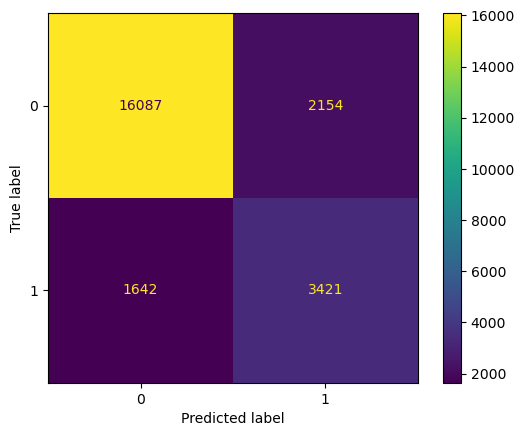

In [77]:
# baseline at predict proba = 0.5

ConfusionMatrixDisplay.from_estimator(random_search_RF.best_estimator_, X_train, y_train)

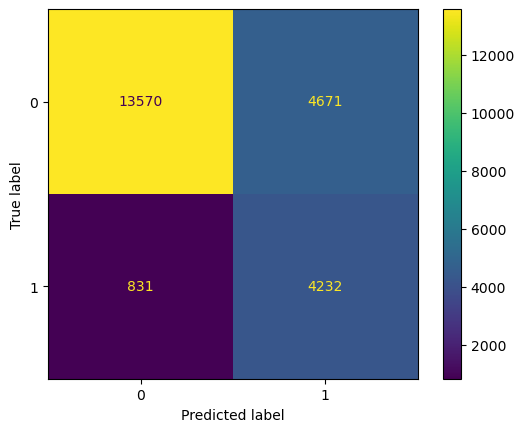

In [92]:
# 0.38 threshold

threshold = 0.38
y_pred = (random_search_RF.best_estimator_.predict_proba(X_train)[:, 1] > threshold).astype('float')
matrix = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In this example by reducing to the `predict_proba` threshold to 0.38, we reduce the number of type II errors by half, achieving 0.836 recall. Note that this does come at the cost of more overall error -- 5502 incorrect labels instead of 3796, but the vast majority of these errors are type I false positives. Because type II errors (unidentified defaults) are more damaging in the credit prediction context, this trade-off is probably worth it.